In [75]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


C:\Users\kyp10_000\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


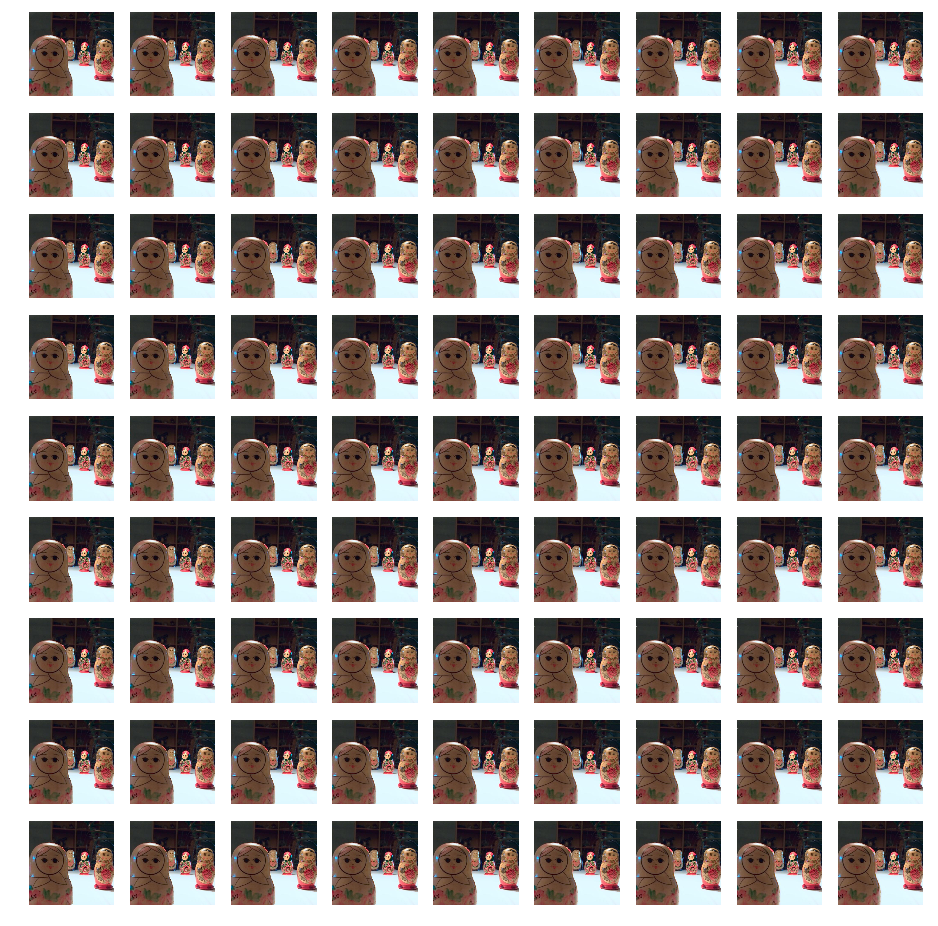

In [318]:
import scipy.io
import itertools

def load_lightfield(name, size):
    image = imread(name)
    h, w, _ = image.shape
    single_size = h//size
    result = zeros((size,size,single_size,single_size,3), dtype=image.dtype)
    borders = linspace(0, h, size+1)[:-1]
    for ix, x in enumerate(borders):
        for iy, y in enumerate(borders):
            result[ix][iy] = image[x:x+single_size,y:y+single_size]
    return array(result)

def show_lightfield(image_array):    
    figure(figsize=(16,16))
    for idx, (x, y) in enumerate(itertools.product(range(image_array.shape[0]), range(image_array.shape[1]))):
        subplot(image_array.shape[0],image_array.shape[1],idx+1)
        axis('off')
        imshow(image_array[x][y])
    

lightfield = load_lightfield("9x9/matrioska.jpg", 9)
#lightfield = load_lightfield("17x17/headlf.jpg", 17)
show_lightfield(lightfield)

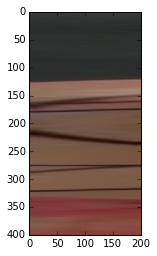

In [312]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

def slice_horizontal(lightfield, y_position):
    middle = lightfield.shape[0]/2
    result = zeros_like(lightfield[0,0])[:,:lightfield.shape[1],:]
    for x in range(result.shape[0]):
        for iy, y in enumerate(range(lightfield.shape[1])):            
            result[x,y] = lightfield[middle,y,x,y_position] 
    return result


def plot_horizontal(y_pos):    
    res = slice_horizontal(lightfield, y_pos)
    res = scipy.misc.imresize(res, (400, 200))
    imshow(res)
    #axis('off')
    #imshow(res)

fig = plt.figure(figsize=(6.5, 2.5))
    
#anim = animation.FuncAnimation(fig, plot_horizontal, frames=400, interval=50)
interact(plot_horizontal, y_pos=(0, 400, 1))
display_animation(anim, default_mode='once')

<function __main__.plot_vertical>

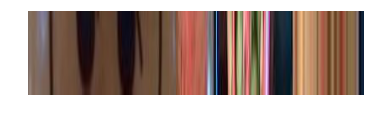

In [319]:
from ipywidgets import interact

def slice_vertical(lightfield, x_position):
    middle = lightfield.shape[1]/2
    result = zeros_like(lightfield[0,0])[:lightfield.shape[0],:,:]
    for y in range(result.shape[1]):
        for ix, x in enumerate(range(lightfield.shape[0])):            
            result[x,y] = lightfield[x,middle,x_position,y] 
    return result

def plot_vertical(x_pos):    
    res = slice_vertical(lightfield, x_pos)
    res = scipy.misc.imresize(res, (100, 400))
    axis('off')
    imshow(res)

interact(plot_vertical, x_pos=(0, 400, 1))

(400L, 400L, 3L)


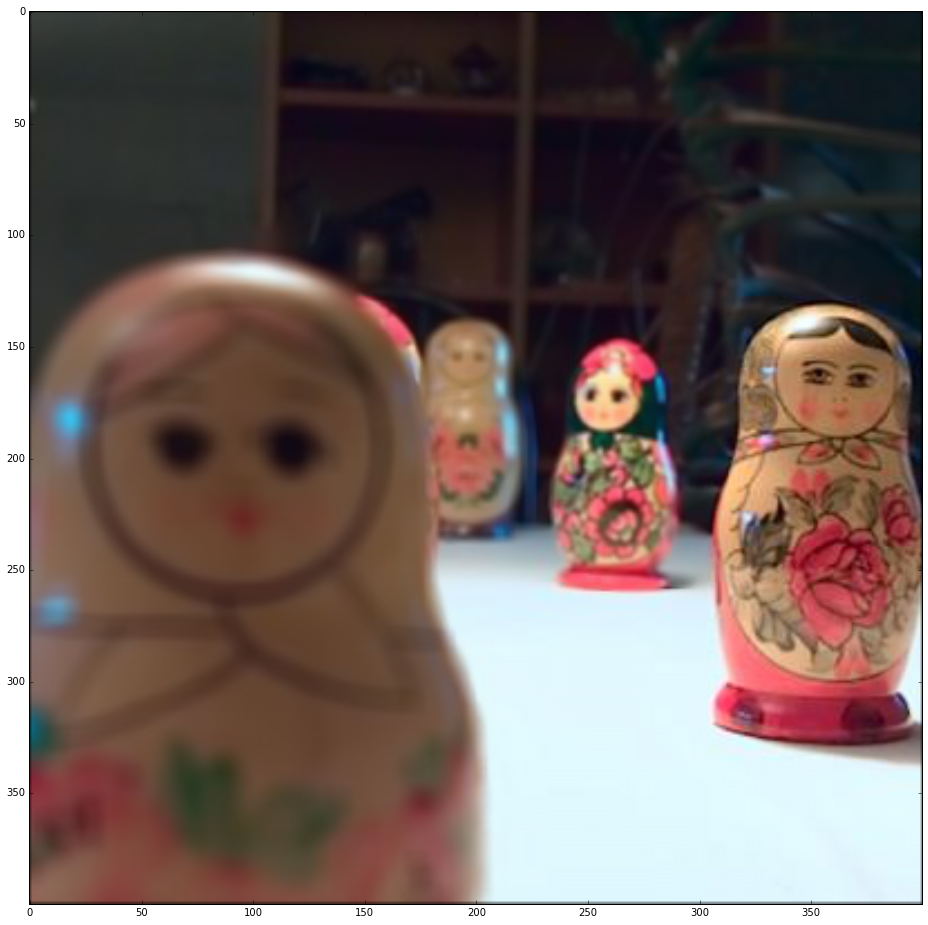

In [317]:
from scipy import ndimage

def get_focused(lightfield, factor):
    max_index = lightfield.shape[0]
    middle_index = max_index / 2
    aggregated_image = zeros_like(lightfield[0,0], dtype=float)
    #aggregated_image = numpy.pad(aggregated_image, ((max_index, max_index),(max_index, max_index),(0,0)), 'constant')

    print aggregated_image.shape
    for x in range(max_index):
        for y in range(max_index):
            x_translation = factor*(middle_index-x)
            y_translation = factor*(middle_index-y)
            current_image = lightfield[x,y].astype(float)
            transformed_image = scipy.ndimage.interpolation.shift(current_image, (x_translation, y_translation, 0))
            aggregated_image = aggregated_image + transformed_image/(max_index*max_index*255)
    return aggregated_image

focused = get_focused(lightfield, .01)

#aggregated_image /= 81
figure(figsize=(16,16))
imshow(focused)

In [320]:
def preview_1d(array):
    resized = scipy.misc.imresize(array[None,:], (100, array.shape[0]))
    axis('off')
    imshow(resized)

C:\Users\kyp10_000\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


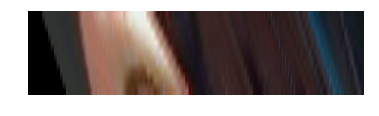

In [321]:
epi = slice_vertical(lightfield, 124)
print epi.shape
def remap_epi(epi, alpha):
    new_epi = zeros_like(epi)
    for u in range(epi.shape[0]):
        for x in range(epi.shape[1]):
            new_x = x+((u*1.0)/epi.shape[0]+0.5)*45*(1-1/alpha)
            if new_x > 0 and new_x < epi.shape[1]:
                new_epi[u,x] = epi[u,new_x]
    return new_epi

def plot_remapped(alpha):
    remapped = remap_epi(epi, alpha)
    res = scipy.misc.imresize(remapped, (100, 400))
    axis('off')
    imshow(res)
    
interact(plot_remapped, alpha=(.5,2,0.007))

C:\Users\kyp10_000\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


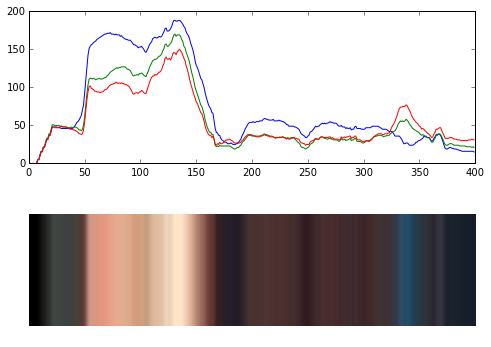

In [259]:
# equation 2
def integrate_sheared(epi):
    return sum(epi, axis=0)/epi.shape[0]

used_epi = remap_epi(epi, 0.75)
preview_epi = integrate_sheared(used_epi)[None,:,:]
figure(figsize=(8,6))
subplot(2,1,1)
plot(integrate_sheared(used_epi))
subplot(2,1,2)
preview = scipy.misc.imresize(preview_epi, (100, epi.shape[1]))
axis('off')
imshow(preview)

(400L,)


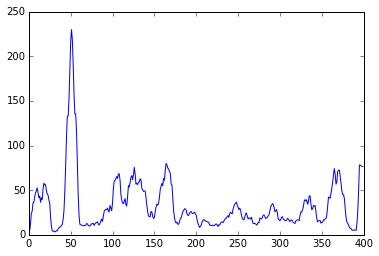

In [294]:
# equation 3
def defocus_response(L_alpha, window_size=9):
    #laplaced = scipy.ndimage.filters.laplace(L_alpha)
    laplaced = convolve(sum(L_alpha,axis=1), [1,1,1,1,-8,1,1,1,1], 'same')
    absed = numpy.abs(laplaced)
    #return convolve(absed[:,0], ones(window_size, dtype=float)/window_size, 'same')
    return convolve(absed, ones(window_size, dtype=float)/window_size, 'same')

sample_defocus = defocus_response(integrate_sheared(used_epi))
print sample_defocus.shape
#preview_1d(sample_defocus)
plot(sample_defocus)

C:\Users\kyp10_000\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


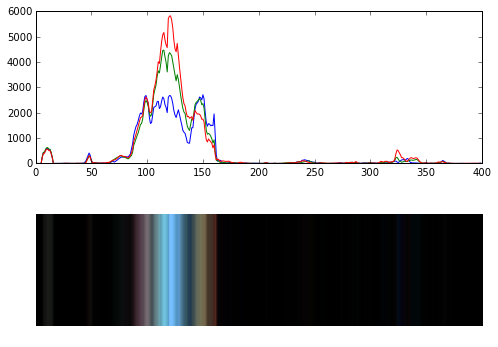

In [296]:
# equation 4
def angular_variance(L_alpha, integrated):
    return (1.0/L_alpha.shape[0])*sum((L_alpha-integrated)**2, axis=0)

used_epi = remap_epi(epi, 0.8)
variance = angular_variance(used_epi, integrate_sheared(used_epi))
figure(figsize=(8,6))
subplot(2,1,1)
plot(variance)
subplot(2,1,2)
preview_1d(variance)

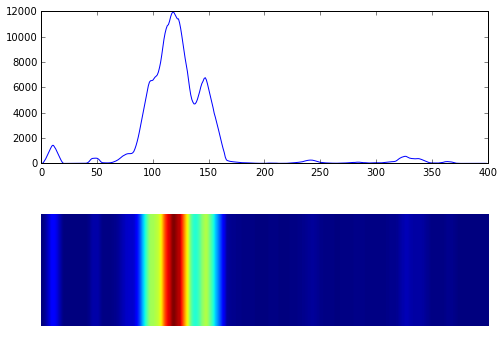

In [297]:
# equation 5
def patch_difference(variance, window_size=9):
    return sum([convolve(variance[:,i], ones(window_size, dtype=float)/window_size, 'same') for i in [0,1,2]], axis=0)

patch_diff = patch_difference(variance)

figure(figsize=(8,6))
subplot(2,1,1)
plot(patch_diff)
subplot(2,1,2)
preview_1d(patch_diff)

In [302]:
lightfield = load_lightfield("9x9/matrioska.jpg", 9)
xsize = lightfield.shape[2]
ysize = lightfield.shape[3]

alphas = linspace(.5,2,num=100)
D_alpha = zeros((alphas.shape[0],xsize,ysize), dtype=float)
C_alpha = zeros((alphas.shape[0],xsize,ysize), dtype=float)

for y in range(ysize):
    epi = slice_vertical(lightfield, y)
    for idx, alpha in enumerate(alphas):
        remapped = remap_epi(epi, alpha)
        integrated = integrate_sheared(remapped)
        D_alpha[idx,y,:] = defocus_response(integrated)
        variance = angular_variance(remapped, integrated)
        C_alpha[idx,y,:] = patch_difference(variance)

C:\Users\kyp10_000\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\kyp10_000\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


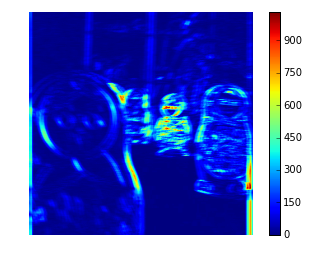

In [303]:
def show(i): 
    axis('off')
    imshow(D_alpha[i])
    colorbar()
    
interact(show, i=(0,99,1))

In [304]:
# equation 6
alpha_D_star = argmax(D_alpha, axis=0)
alpha_C_star = argmin(C_alpha, axis=0)

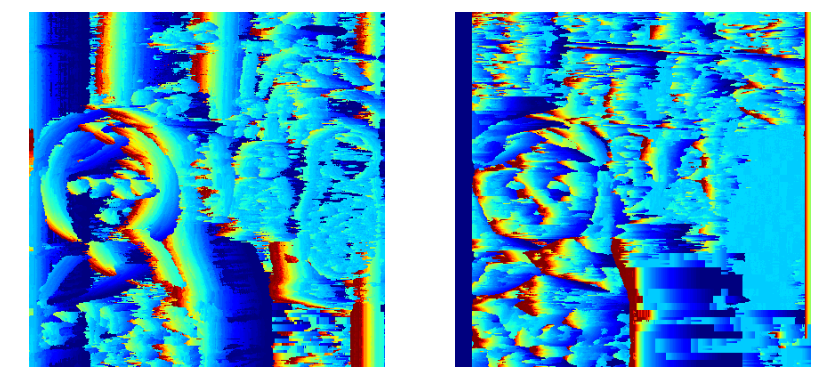

In [311]:
figure(figsize=(14,14))
subplot(1,2,1)
axis('off')
imshow(alpha_D_star)
subplot(1,2,2)
axis('off')
imshow(alpha_C_star)

In [306]:
D_alpha_prime = D_alpha.copy()
print D_alpha_prime.shape
print alpha_D_star.shape
for x in range(alpha_D_star.shape[0]):
    for y in range(alpha_D_star.shape[1]):
        for dir in [(-1,0),(1,0)]:
            curval = D_alpha_prime[alpha_D_star[x,y],x,y]
            D_alpha_prime[alpha_D_star[x,y],x,y] = 0
            nx = x+dir[0]
            ny = y+dir[1]
            while nx > 0 and nx < xsize and ny > 0 and ny < ysize:
                newval = D_alpha_prime[alpha_D_star[nx,ny],nx,ny]
                if newval > curval:
                    break
                D_alpha_prime[alpha_D_star[nx,ny],nx,ny] = 0
                nx += dir[0]
                ny += dir[1]
                curval = newval
                          
alpha_D_star_2 = argmax(D_alpha_prime, axis=0)

(100L, 400L, 400L)
(400L, 400L)


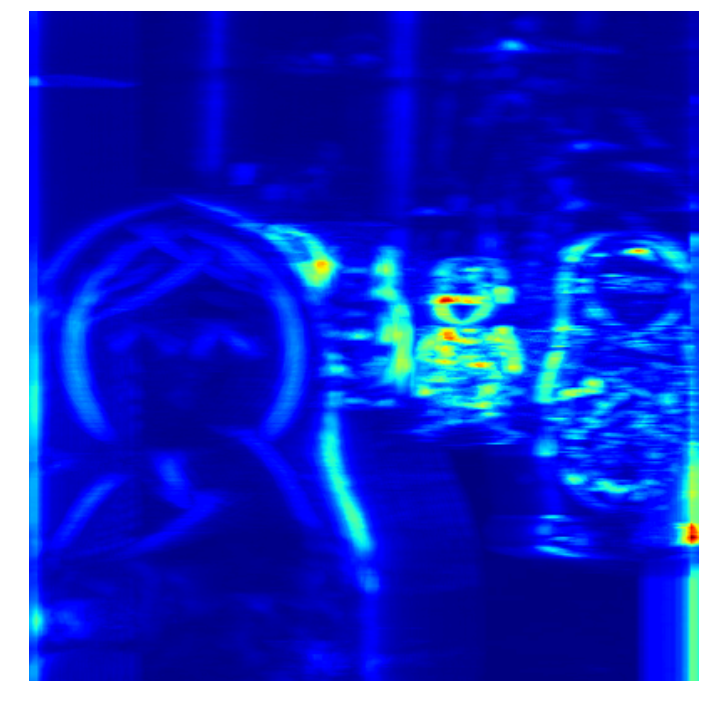

In [307]:
def filter_layered(stack, filter):
    d1 = zeros_like(filter, dtype=float)
    for x in range(xsize):
        for y in range(ysize):
            d1[x,y] = stack[filter[x,y],x,y]
    return d1

figure(figsize=(12,12))
axis('off')            
imshow(filter_layered(D_alpha, alpha_D_star))

<matplotlib.colorbar.Colorbar instance at 0x00000000406327C8>

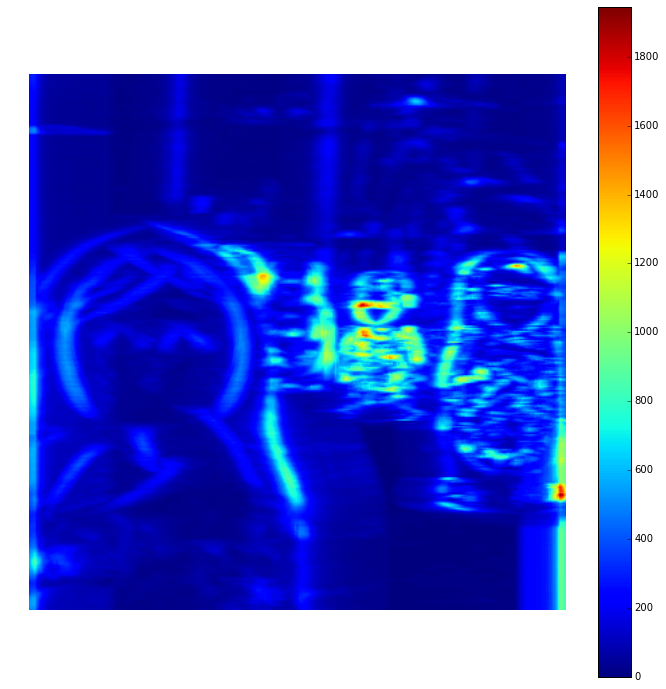

In [308]:

figure(figsize=(12,12))
axis('off')            
imshow(filter_layered(D_alpha, alpha_D_star_2))
colorbar()

C:\Users\kyp10_000\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
C:\Users\kyp10_000\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


<matplotlib.colorbar.Colorbar instance at 0x0000000037DD5C48>

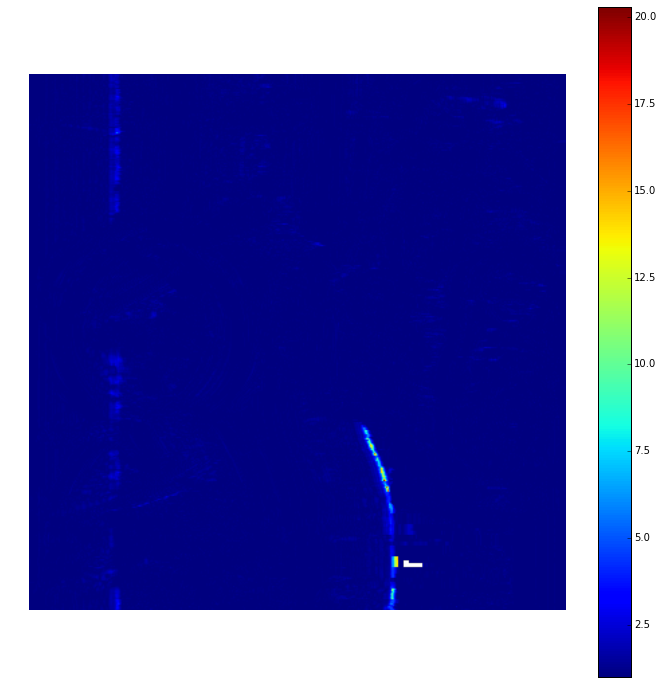

In [309]:
# equation 7
D_confidence = filter_layered(D_alpha, alpha_D_star)/filter_layered(D_alpha, alpha_D_star_2)

figure(figsize=(12,12))
axis('off')       
imshow(D_confidence)     
colorbar()

In [200]:
C_alpha_prime = C_alpha.copy()
for x in range(alpha_C_star.shape[0]):
    for y in range(alpha_C_star.shape[1]):
        for dir in [(-1,0),(1,0)]:
            curval = C_alpha_prime[alpha_C_star[x,y],x,y]
            C_alpha_prime[alpha_C_star[x,y],x,y] = 100000
            nx = x+dir[0]
            ny = y+dir[1]
            while nx > 0 and nx < xsize and ny > 0 and ny < ysize:
                newval = C_alpha_prime[alpha_C_star[nx,ny],nx,ny]
                if newval < curval:
                    break
                C_alpha_prime[alpha_C_star[nx,ny],nx,ny] = 100000
                nx += dir[0]
                ny += dir[1]
                curval = newval
                          
alpha_C_star_2 = argmin(C_alpha_prime, axis=0)

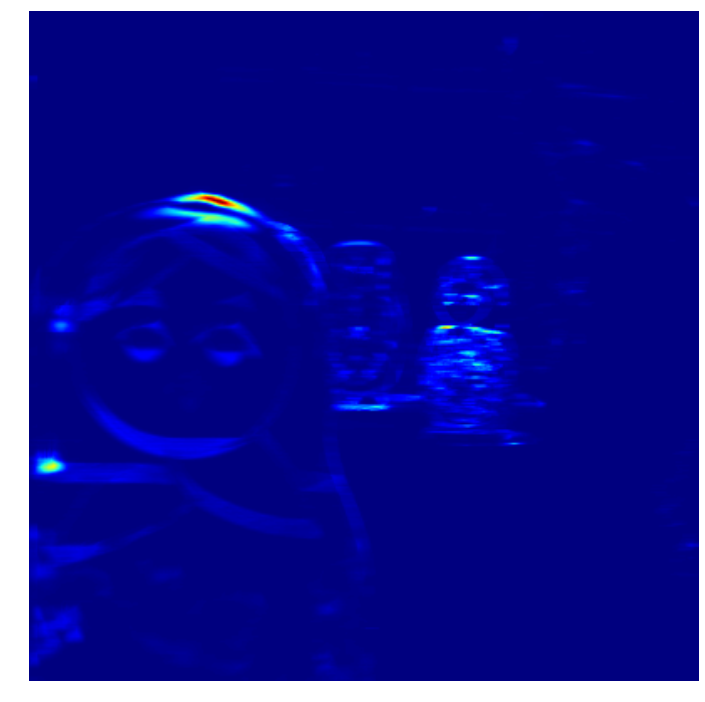

In [201]:
figure(figsize=(12,12))
axis('off')            
imshow(filter_layered(C_alpha, alpha_C_star))

<matplotlib.colorbar.Colorbar instance at 0x0000000030725BC8>

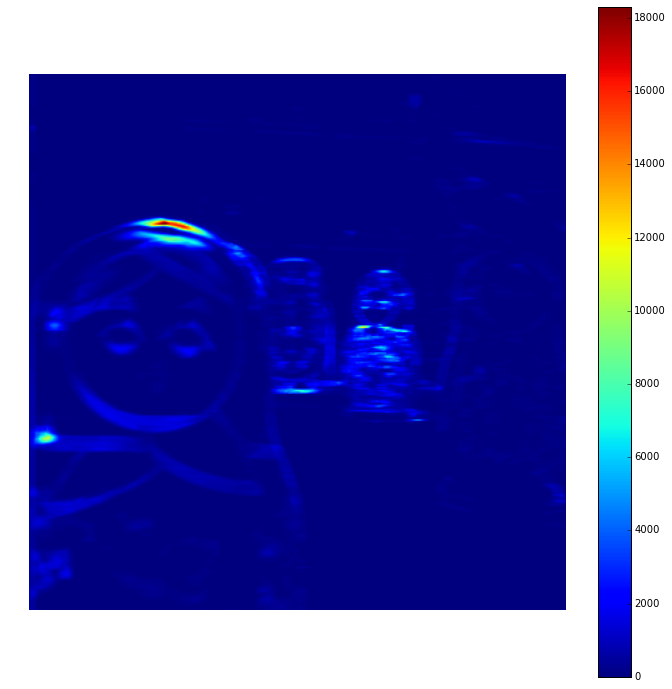

In [202]:
figure(figsize=(12,12))
axis('off')            
imshow(filter_layered(C_alpha, alpha_C_star_2))
colorbar()

C:\Users\kyp10_000\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


<matplotlib.colorbar.Colorbar instance at 0x00000000188F5808>

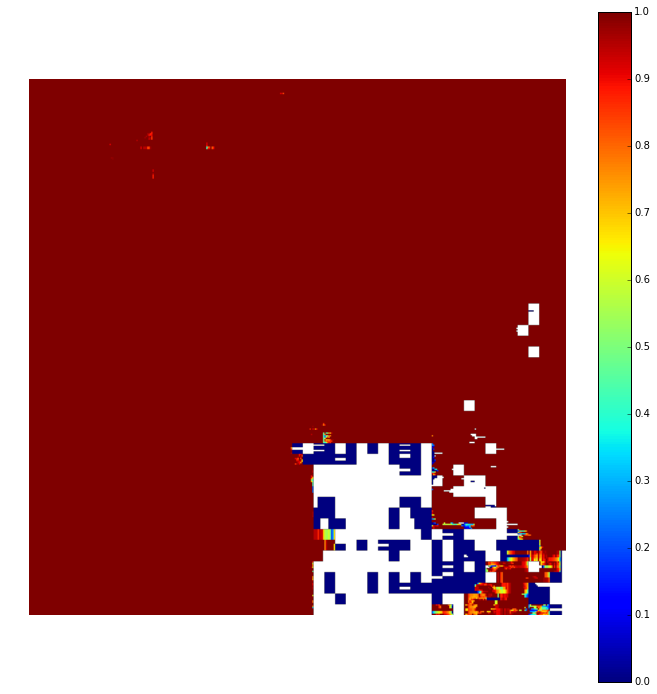

In [198]:
# equation 7 (2)
C_confidence = filter_layered(C_alpha, alpha_C_star)/filter_layered(C_alpha, alpha_C_star_2)

figure(figsize=(12,12))
axis('off')       
imshow(C_confidence)     
colorbar()

In [ ]:
def shear_4d(frame, alpha):
    